# 数据和模型 Data and Models

<img src="https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/images/logo.png" width=150>

目前为止，我们看到了应对不同任务（回归/分类）而建立在不同数据集上的多种模型，在后续的课程中，我们将继续学习更多算法。但是，我们忽略了一个关于数据和模型的根本问题：质量和数量。简而言之，一个机器学习模型消耗输入数据，产生预测结果。用于训练的数据质量和数量，直接决定了预测的质量。垃圾数据产生垃圾结果。

<img src="https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/images/nutshell.png" width=500>





# 配置 Set Up

我们通过具体的代码示例，了解所有的概念。首先，我们人工制造一些训练模型的数据。任务是根据白细胞的数量和血压预测肿瘤是良性还是恶性。

In [1]:
# Load PyTorch library
!pip3 install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch

In [3]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [4]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True,
    data_file="tumors.csv",
    reduced_data_file="tumors_reduced.csv",
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=100,
    learning_rate=1e-3,
    num_epochs=100,
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: False


# 数据 Data

In [5]:
import re
import urllib

In [6]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/data/tumors.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [7]:
# Raw data
df = pd.read_csv(args.data_file, header=0)
df.head()

,leukocyte_count,blood_pressure,tumor
0,13.472969,15.250393,1
1,10.805510,14.109676,1
2,13.834053,15.793920,1
3,9.572811,17.873286,1
4,7.633667,16.598559,1


In [8]:
def plot_tumors(df):
    i = 0; colors=['r', 'b']
    for name, group in df.groupby("tumor"):
        plt.scatter(group.leukocyte_count, group.blood_pressure, edgecolors='k',
                   color=colors[i]); i += 1
    plt.xlabel('leukocyte count')
    plt.ylabel('blood pressure')
    plt.legend(['0 - benign', '1 - malignant'], loc="upper right")
    plt.show()

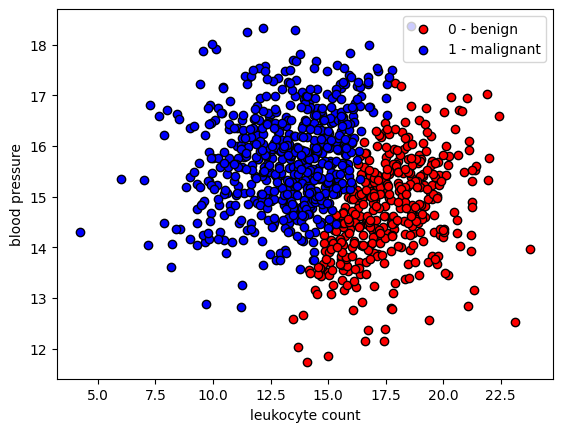

In [9]:
# Plot data
plot_tumors(df)

In [12]:
# Convert to PyTorch tensors
X = df[['leukocyte_count', 'blood_pressure']].to_numpy()
y = df[['tumor']].to_numpy()
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.ravel()).long()

In [13]:
# 打乱数据 Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx]
y_train = y[:test_start_idx]
X_test = X[test_start_idx:]
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 750 train samples and 250 test samples.


# 模型 Model

基于这个人造数据训练模型。

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [15]:
# 多层感知 Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [16]:
# Initialize model
model = MLP(input_dim=len(df.columns)-1,
            hidden_dim=args.num_hidden_units,
            output_dim=len(set(df.tumor)))

In [17]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [18]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [19]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)

    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Verbose
    if t%20==0:
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 4.5713 | accuracy: 38.4%
epoch: 20 | loss: 0.9313 | accuracy: 61.6%
epoch: 40 | loss: 0.3875 | accuracy: 95.7%
epoch: 60 | loss: 0.2834 | accuracy: 98.5%
epoch: 80 | loss: 0.1849 | accuracy: 98.3%


In [20]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [21]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 98.8%, test acc: 98.0%


In [22]:
# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

我们将绘制一个白色点，这个点已知是一个恶性肿瘤。我们训练后的模型可以精确的预测它确实是一个恶性肿瘤。

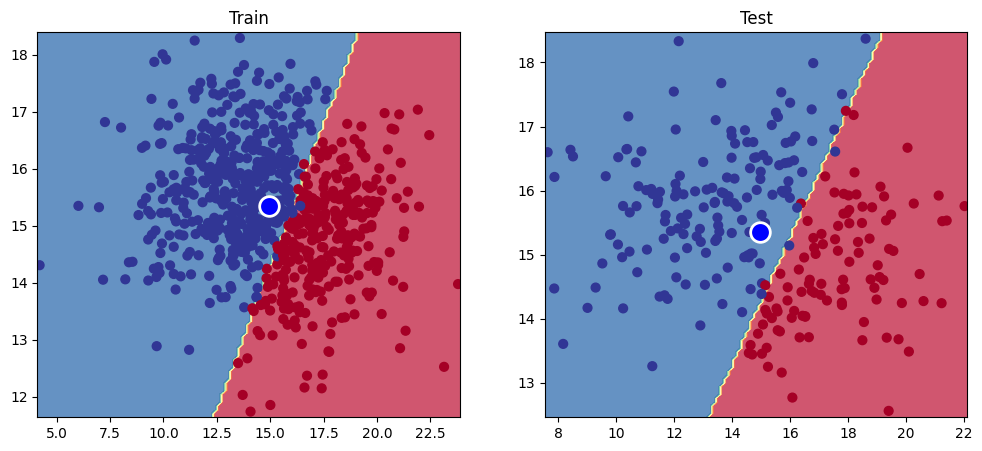

In [23]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200,
            c='b', edgecolor='w', linewidth=2)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200,
            c='b', edgecolor='w', linewidth=2)
plt.show()

完美！我们得到了测试和训练上非常好的表现。我们将用这个数据展示数据质量和数量的重要性。

# 数据质量和数量 Data Quality and Quantity

我们去除决策边界附件的一些训练数据，观察模型的鲁棒性如何。

In [24]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/data/tumors_reduced.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.reduced_data_file, 'wb') as fp:
    fp.write(html)

In [25]:
# Raw reduced data
df_reduced = pd.read_csv(args.reduced_data_file, header=0)
df_reduced.head()

,leukocyte_count,blood_pressure,tumor
0,13.472969,15.250393,1
1,10.805510,14.109676,1
2,13.834053,15.793920,1
3,9.572811,17.873286,1
4,7.633667,16.598559,1


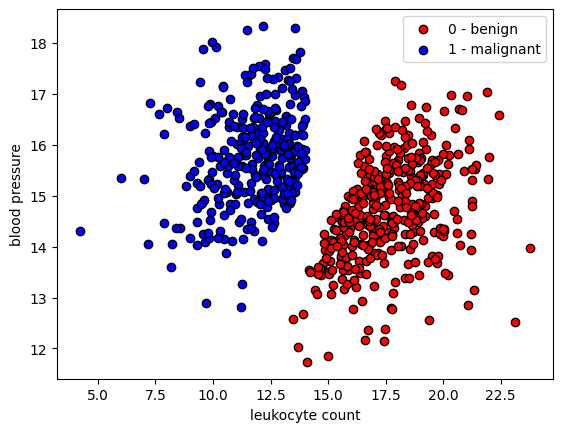

In [26]:
# Plot data
plot_tumors(df_reduced)

In [27]:
# Convert to PyTorch tensors
X = df_reduced[['leukocyte_count', 'blood_pressure']].to_numpy()
y = df_reduced[['tumor']].to_numpy()
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.ravel()).long()

In [28]:
# Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx]
y_train = y[:test_start_idx]
X_test = X[test_start_idx:]
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 540 train samples and 180 test samples.


In [29]:
# Initialize model
model = MLP(input_dim=len(df_reduced.columns)-1,
            hidden_dim=args.num_hidden_units,
            output_dim=len(set(df_reduced.tumor)))

In [30]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [31]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)

    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Verbose
    if t%20==0:
        print ("epoch: {0} | loss: {1:.4f} | accuracy: {2:.1f}%".format(t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 0 | loss: 0.8863 | accuracy: 54.8%
epoch: 20 | loss: 0.2772 | accuracy: 100.0%
epoch: 40 | loss: 0.1267 | accuracy: 100.0%
epoch: 60 | loss: 0.0708 | accuracy: 100.0%
epoch: 80 | loss: 0.0482 | accuracy: 100.0%


In [32]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [33]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 100.0%, test acc: 100.0%


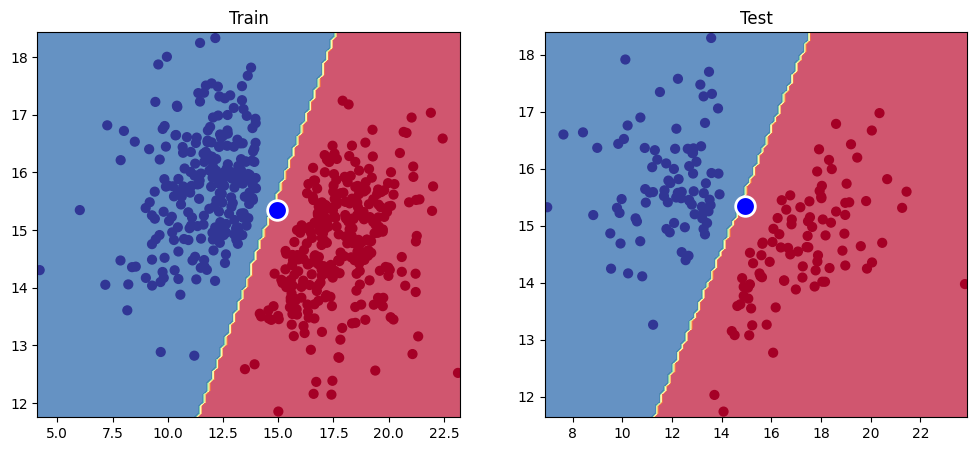

In [34]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200,
            c='b', edgecolor='w', linewidth=2)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200,
            c='b', edgecolor='w', linewidth=2)
plt.show()

这是一个非常惊人而又现实的情景。基于我们删减的人造数据，我们得到了一个在测试数据上表现非常好的模型。但是，当我们我使用之前相同的白色点（已知是良性肿瘤）进行测试时，预测显示是一个恶性肿瘤。我们完全误判了肿瘤。

**模型不是水晶球**
在开始机器学习之前，很重要的一点是：我们需要观察我们的数据，并且扪心自问他们是否真实表示了我们将解决的问题。如果开始时的数据质量很差，即使训练很好，并且在测试数据上也很一致，这个模型依然是不可信的。

# 模型 Models

一旦你自信地认为你的数据质量和数量都非常好，你可以开始思考模型了。你选择模型的类型取决于很多因素，包括：任务、数据类型、需求复杂度等。

<img src="https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/images/models1.png" width=550>

当你一旦搞清楚你的任务需要的模型类型时，从一个简单的模型开始，逐渐增加复杂度。你肯定不想直接从神经网络开始，因为很可能不是你数据和任务的正确模型。平衡模型的复杂度是你数据科学生涯的主要关键任务。**简单模型 → 复杂模型**